## **Trabajo Práctico Final: Bank Subscription**
____
__Universidad Tecnológica Nacional, Buenos Aires__\
__Ingeniería Industrial__\
__Ciencia de Datos - Curso I5521__
____

Alumnos:
---

---


- Nombre: Facundo   
- Apellido: Perez   
- Legajo: 168410-3  


---


- Nombre: Facundo   
- Apellido: Castro  De Rosa
- Legajo:  161377-7


---



# **Bank Subscription**

> Introducción: El objetivo es predecir que clientes se subscribirán a una campaña de marketing. Para ello, se nos presentará un dataset con una cartera de clientes de 45.211 personas con 17 variables que muestran algunas características de los clientes en el banco.

>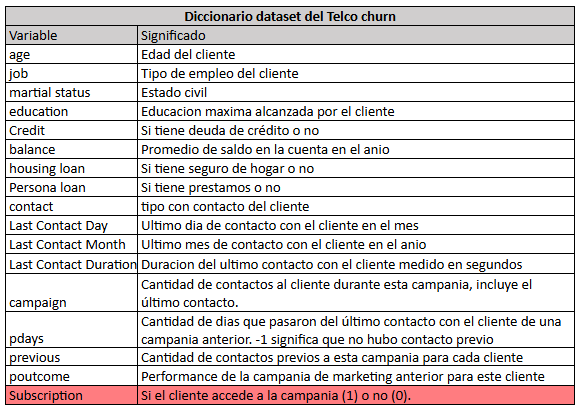

##**Librerías**

In [ ]:
# Importamos librerías de maniupulación de datos
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



In [ ]:
# Importamos librerías de Aprendizaje automático
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.utils import resample

# Importamos librerias de PCA
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Importamos libreria de Google Drive Colab para poder leer el dataset
from google.colab import drive
drive.mount('/content/drive/')

#Importo el dataset, los valores estan separados por ";" por lo cual identificamos el separador al importar
bank = pd.read_csv('/content/drive/My Drive/bank_subscription.csv',sep=';')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
bank.shape

(45211, 17)

In [ ]:
#####BALANCEO DE DATOS########
# Dividir el dataset en dos grupos: Subscription=1 y Subscription=0
group_1 = bank[bank['Subscription'] == 1]
group_0 = bank[bank['Subscription'] == 0]

# Resamplear el grupo con Subscription=1
group_1_resampled = resample(group_1,
                             replace=False,  # No Permitir duplicados
                             n_samples=5000,  # Número de muestras deseado
                             random_state=42)

# Resamplear el grupo con Subscription=0
group_0_resampled = resample(group_0,
                             replace=False,  # No se permiten duplicados
                             n_samples=3000,  # Número de muestras deseado
                             random_state=42)

# Combinar los dos grupos resampleados
balanced_data = pd.concat([group_1_resampled, group_0_resampled])

# Mezclar el dataset para eliminar cualquier orden
bank = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
# Eliminamos registros duplicados
bank.drop_duplicates(inplace=True,keep='first')

In [ ]:
bank.shape

(8000, 17)

In [ ]:
# Reemplazamos las variables categoricas yes no por 1 y 0 respectivamente
bank['Credit'] = bank['Credit'].map({'yes': 1, 'no': 0})
bank['Housing Loan'] = bank['Housing Loan'].map({'yes': 1, 'no': 0})
bank['Personal Loan'] = bank['Personal Loan'].map({'yes': 1, 'no': 0})

In [ ]:
# Podemos tomar dos caminos, eliminar los registors con valores nulos, o tratar de recuperar información de los mismos.

# Para evitar eliminar registros con valores nulos, podemos:
# En edad podemos asignar el promedio de las edades del dataset
# A los valores nulos en Job,Education podemos asignarle el valor "Unknown"
# A los valores nulos en Marital Status podemos asignarles el valor más repetido (married) o crear uno nuevo llamado "Unknown"
# A los valores nulos en Credit podemos asignar "no", (si tuvieran deuda, creería que el banco no lo pasaría por alto).
# A los valores en Balance (euros) les podemos asignar cero.
# A los nulos en Housing Loan se les puede asignar Yes por ser el valor mayoritario. Lo mismo en Personal Loan, podemos asignar "no"
# A los nulos en Last Contact Duration podemos asignar 0, o un promedio.
# Para Pdays, podemos calcular los dias en base al mes y el dia, por ejemplo para el primer registro, el 5 May es Pdays = -1


# Dado que el dataset es de 45.211 y hay una cierta cantidad de nulos (4973) que parecieran estar en los mismos registros,
# la información que se puede recuperar de los mismos, no resultaría muy relevante.
# Por lo cual optamos por eliminar estos valores


In [ ]:
# Resulta que los valores nulos no pertenecen a los mismos registors entre si,
# por lo cual iremos por el segundo camino de buscar recuperar registros

#Asignamos el promedio de edad en los valores nulos de la variable Age:
bank['Age'].fillna(bank['Age'].mean(),inplace=True)

# A los valores nulos en Job,Education, Marital Status asignamos "Unknown":
bank['Job'].fillna('Unknown',inplace=True)
bank['Education'].fillna('Unknown',inplace=True)
bank['Marital Status'].fillna('Unknown',inplace=True)

# A los valores nulos en Credit asignamos "no" 0:
bank['Credit'].fillna(0,inplace=True)

# A los nulos en Balance (euros) le asignamos cero:
bank['Balance (euros)'].fillna(0,inplace=True)

# A los nulos en Housing Loan le asignamos "yes" 1:
bank['Housing Loan'].fillna(1,inplace=True)

# A los nulos en Personal Loan, podemos asignar "no" 0:
bank['Personal Loan'].fillna(0,inplace=True)


In [ ]:
# A los nulos en Last Contact Duration asignamos 0
bank['Last Contact Duration'].fillna(bank['Last Contact Duration'].mean(),inplace=True)

# A los nulos en Pdays asignamos -1 (se considera que no hubo contacto)
bank['Pdays'].fillna(-1,inplace=True)



In [ ]:
# Generamos variables categoricas (dummies) para:
# Job, Marital status, Education, Contact, Poutcome
bank = pd.get_dummies(bank,columns=['Job','Marital Status','Education','Contact','Poutcome'])



In [ ]:
# Eliminamos las variables Last Contact Day y Last Contact Month que no contienen información relevante
bank.drop(['Last Contact Day','Last Contact Month'],axis=1,inplace=True)

In [ ]:
bank.shape

(8000, 39)

In [ ]:
# Una vez concluido el analisis exploratorio, continuamos con la etapa de ML.
# Podemos volver a hacer modificaciones en el dataset para buscar mejorar los resultados

#**Pipeline**
>Desarrollar en python un pipeline de Machine Learning para predecir la variable subscription. Aplicar también algún método de la reducción de la dimensionalidad visto en clase y volver a predecir el problema en cuestión.

In [ ]:
# Dividimos nuestro dataset en la variable dependiente "y" (label o etiqueta) y las variables independientes "x"

y = np.array  (bank['Subscription'])
x = bank.drop(['Subscription'],axis=1)

In [ ]:
# Dividimos el dataset entre Train y Test, tomamos un test_size del 30%:

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.10, random_state=42)

In [ ]:
# Escalamos nuestros datos de xtrain e xtest

scaler = preprocessing.StandardScaler().fit(xtrain)

xtrain_scal = scaler.transform(xtrain)

xtest_scal =scaler.transform(xtest)

# **LR**

In [ ]:
# defino modelo LR llamado model_lr
# (OJO! no estamos haciendo grid-search)
model_lr = LogisticRegression()

In [ ]:
# realizo un cross validation de 5 folds para ver la performance del modelo con distintas particiones de entrenamiento
cv_results = cross_validate(model_lr, xtrain_scal, ytrain, cv=5)

In [ ]:
# analizamos los resultados de cada iteracion del cross validation.
# Este objeto indica el tiempo que tomo cada iteracion, y en "test_score" cuanto dio el resultado de accuracy
cv_results

{'fit_time': array([0.01099992, 0.00499058, 0.00499988, 0.00500035, 0.00503922]),
 'score_time': array([0.00100946, 0.00099993, 0.00099945, 0.        , 0.00096083]),
 'test_score': array([0.80069444, 0.79166667, 0.78125   , 0.78888889, 0.79652778])}

In [ ]:
# estudiamos como fue el promedio de todos los accuracys a lo largo de todas las iteraciones de cross validation
np.mean(cv_results['test_score'])

0.7918055555555554

In [ ]:
# Ajusto mi modelo a las muestras de training utilizando tanto Xtrain como Ytrain
model_lr.fit(xtrain_scal, ytrain)

LogisticRegression()

In [ ]:
# Genero predicciones con mi modelo entrenado para las muestras de Test, utilizando solo Xtest
ypred = model_lr.predict(xtest_scal)

In [ ]:
# Computo el accuracy (comparar ytest vs ypred)
test_acc = accuracy_score(ytest, ypred)
print("El accuracy es " + str(test_acc))

El accuracy es 0.815


In [ ]:
#compute and plot AUC
yproba = model_lr.predict_proba(xtest_scal)
fpr1, tpr1, thresholds = roc_curve(ytest.astype('int'), yproba[:,1], drop_intermediate = False)
auc = metrics.auc(fpr1, tpr1)
print("El AUC es = " + str(auc))

El AUC es = 0.869737227053911


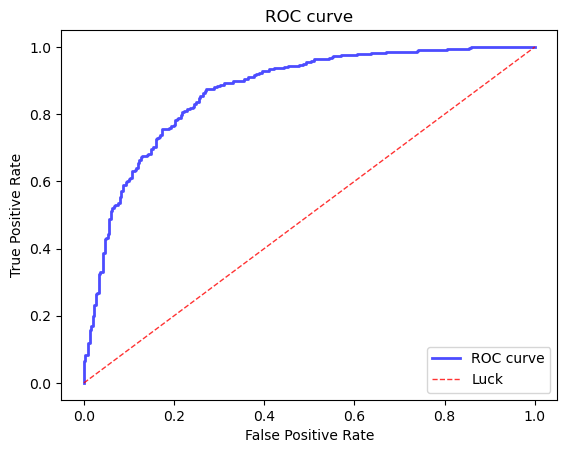

In [ ]:
plt.plot(fpr1, tpr1, lw=2, alpha=0.7 , label = 'ROC curve', color = 'b')
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='r',label='Luck', alpha=.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(False)
plt.legend(loc="lower right")
plt.title('ROC curve')
plt.show()

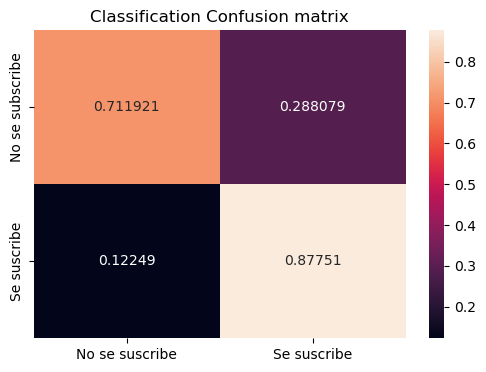

In [ ]:
# Compute confusion Matrix
cm = confusion_matrix(ytest, ypred, normalize = 'true')

df_cm = pd.DataFrame(cm, index = ['No se subscribe', 'Se suscribe'], columns = ['No se suscribe', 'Se suscribe'])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, fmt='g')
plt.title('Classification Confusion matrix')
plt.show()

In [ ]:
# Al haber una mayor cantidad de registros de gente que no se suscribe,
# suele clasificar como que no se suscriben, sin embargo hay un gran error en detectar quienes si se suscriben
# Una alternativa es limitar los datos y poner valores mas balanceados entre etiquetas 0 y 1.
# Update: Poniendo registros mas balanceados disminuye el score general,
# pero predecimos de mejor manera quienes si se sucriben, que es lo que buscmaos detectar

##**SVC**

In [ ]:
#Creamos el modelo Support Vector Classification (SVC)

svc = svm.SVC()

#Los valores posibles de los parametros son:
#kernel: {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable, default=’rbf’
#gamma: {‘scale’, ‘auto’} or float, default=’scale’ -> 1/n_features o float no negativo
#C: float, default=1.0

param_svm = {'kernel':('poly', 'linear'), 'C':[0.5, 1, 5], 'gamma':[0.01,0.05,0.1]}


In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# cv indica la cantidad de folds
# refit nos devuelve el modelo con los mejores parametros encontrados

svc_clf = RandomizedSearchCV(svc, param_distributions = param_svm, refit = True, cv = 5,verbose = 2,n_iter=5,n_jobs=-1)


In [ ]:
svc_clf.fit(xtrain_scal, ytrain.ravel())

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5, estimator=SVC(), n_iter=5, n_jobs=-1,
                   param_distributions={'C': [0.5, 1, 5],
                                        'gamma': [0.01, 0.05, 0.1],
                                        'kernel': ('poly', 'linear')},
                   verbose=2)

In [ ]:
print("The best parameters are %s with a score of %0.2f" % (svc_clf.best_params_, svc_clf.best_score_))
# The best parameters are {'kernel': 'rbf', 'gamma': 0.01, 'C': 1} with a score of 0.90

The best parameters are {'kernel': 'linear', 'gamma': 0.01, 'C': 0.5} with a score of 0.79


In [ ]:
# Hacemos una serie de hiperparametros nuevos a partir de los resultados y volvemos a estimar:

param_svm = {'kernel':('poly', 'rbf'), 'C':[0.01, 1, 10], 'gamma':[ 0.005, 0.05, 0.1 ]}
svc_clf = RandomizedSearchCV(svc, param_distributions = param_svm, refit = True, cv = 5,verbose = 2,n_iter=5,n_jobs=-1)
svc_clf.fit(xtrain_scal, ytrain.ravel())
print("The best parameters are %s with a score of %0.2f" % (svc_clf.best_params_, svc_clf.best_score_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
The best parameters are {'kernel': 'rbf', 'gamma': 0.05, 'C': 1} with a score of 0.78


In [ ]:
# Genero predicciones con mi modelo entrenado para las muestras de Test, utilizando solo Xtest
ypred = svc_clf.predict(xtest_scal)

In [ ]:
# Compute confusion Matrix
cm = confusion_matrix(ytest, ypred,normalize ='true')
cm

array([[0.63907285, 0.36092715],
       [0.11044177, 0.88955823]])

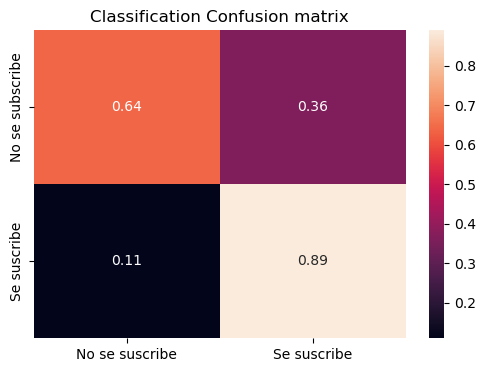

In [ ]:
df_cm = pd.DataFrame(cm, index = ['No se subscribe', 'Se suscribe'], columns = ['No se suscribe', 'Se suscribe'])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, fmt='.2f')
plt.title('Classification Confusion matrix')
plt.show()


In [ ]:
# Al haber una mayor cantidad de registros de gente que no se suscribe,
# suele clasificar como que no se suscriben, sin embargo hay un gran error en detectar quienes si se suscriben
# Una alternativa es limitar los datos y poner valores mas balanceados entre etiquetas 0 y 1.

# **Redes Neuronales**
**Tensor Flow**

In [ ]:
# Importamos librerias de Redes neuronales
import tensorflow as tf #Libreria de Redes Neronales
from  tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential

In [ ]:
# Para eliminar los modelos que hayan quedado guardados en memoria
tf.keras.backend.clear_session()

model = Sequential([
  # Primera capa de la red
  Dense(20,input_dim=38, activation='relu'),
  # Hidden Layers
  Dense(20, activation='relu'),
  Dense(20, activation='relu'),
  # Salida de la red
  Dense(1, activation='sigmoid')
])

In [ ]:
#Veamos la arquitectura de nuestro modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 20)                  │             780 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,641 (6.41 KB)

 Trainable params: 1,641 (6.41 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Optimizador
lr = 0.01
opt = SGD(learning_rate=lr)
# Funcion de penalizacion
# Usar ésta loss cuando tenemos un problema multi-class.
loss_func = BinaryCrossentropy()

In [ ]:
# Hasta este momento, hemos definido los elementos que conformaran el modelo.
# [arquitectura, optimizer, loss function].
# Internamente, estuvimos armando un 'grafo computacional', el cual debe
# compilarse.
model.compile(optimizer = opt,
              loss = loss_func,
              metrics = ['accuracy'])

In [ ]:
# Batch Size
bs = 50
# Epochs de entrenamiento
epochs_training = 100

# Entrenamos!
training = model.fit(xtrain_scal,ytrain, epochs=epochs_training, validation_split=0.2)

Epoch 1/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5422 - loss: 0.6879 - val_accuracy: 0.6146 - val_loss: 0.6584
Epoch 2/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6159 - loss: 0.6523 - val_accuracy: 0.6278 - val_loss: 0.6414
Epoch 3/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6316 - loss: 0.6334 - val_accuracy: 0.6424 - val_loss: 0.6236
Epoch 4/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6511 - loss: 0.6087 - val_accuracy: 0.6625 - val_loss: 0.6028
Epoch 5/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6786 - loss: 0.5921 - val_accuracy: 0.6910 - val_loss: 0.5804
Epoch 6/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7110 - loss: 0.5631 - val_accuracy: 0.7104 - val_loss: 0.5579
Epoch 7/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7266 - loss: 0.5431 - val_accuracy: 0.7292 - val_loss: 0.5378
Epoch 8/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7372 - loss: 0.5224 - val_acc

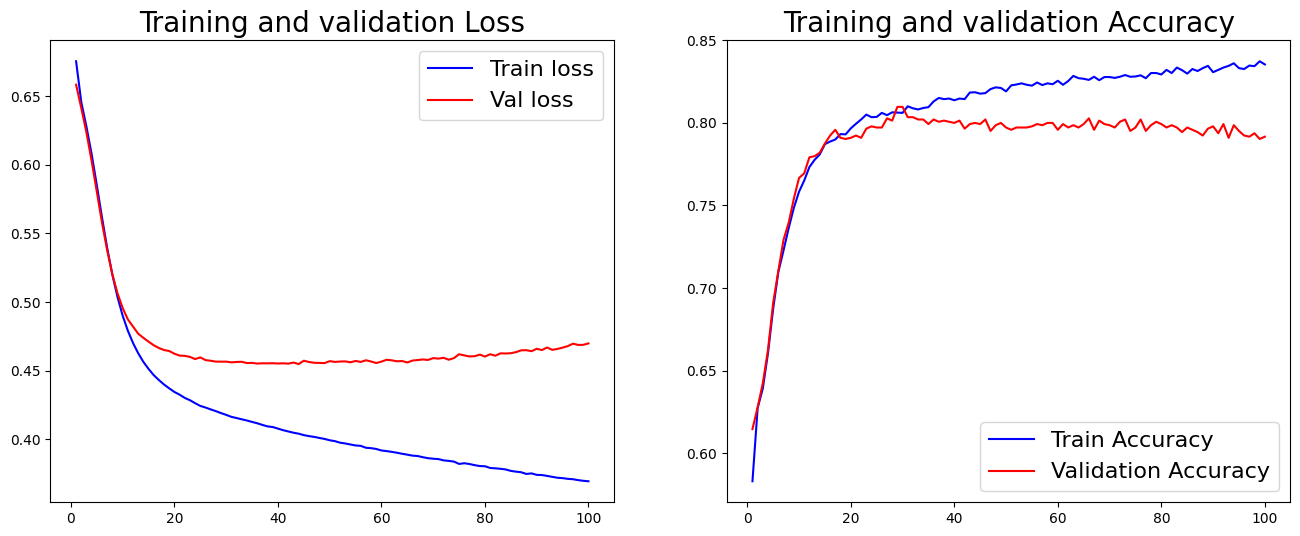

In [ ]:
# El historial de entrenamiento quedó guardado en
# 'history.history', ingresamos como 'key' cada una de las metricas que queremos plotear.

#Loss
loss_history = training.history['loss']
val_loss_hist = training.history['val_loss']

#Accuracy
train_acc_history = training.history['accuracy']
val_acc_hist = training.history['val_accuracy']
epochs = range(1, len(loss_history) + 1)

fig, axs = plt.subplots(1,2,figsize=(16,6))
axs[0].plot(epochs, loss_history, 'b', label='Train loss')
axs[0].plot(epochs, val_loss_hist, 'r', label='Val loss')
axs[0].set_title('Training and validation Loss',fontsize=20)
axs[0].legend(fontsize=16)
axs[1].plot(epochs, train_acc_history, 'b', label='Train Accuracy')
axs[1].plot(epochs, val_acc_hist, 'r', label='Validation Accuracy')
axs[1].set_title('Training and validation Accuracy',fontsize=20)
axs[1].legend(fontsize=16)
plt.show()

In [ ]:
# Test
model.evaluate(xtest_scal, ytest,verbose=2)

25/25 - 0s - 2ms/step - accuracy: 0.7862 - loss: 0.4639


[0.46387386322021484, 0.7862499952316284]

In [ ]:
# CONFUSION MATRIX
y_hat = model.predict(xtest_scal) # Salida de la red
y_pred = (y_hat > 0.5).astype(int) # Clase de la salida

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [ ]:
# Compute confusion Matrix
cm = confusion_matrix(ytest, y_pred,normalize ='true')
cm

array([[0.64569536, 0.35430464],
       [0.12851406, 0.87148594]])

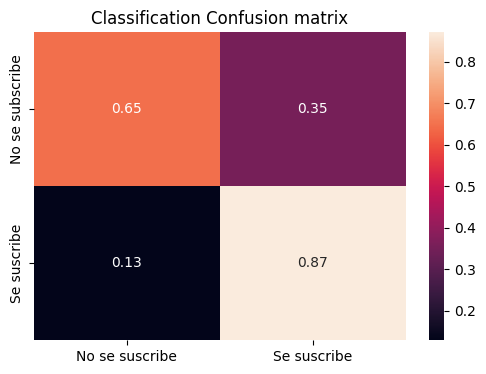

In [ ]:
df_cm = pd.DataFrame(cm, index = ['No se subscribe', 'Se suscribe'], columns = ['No se suscribe', 'Se suscribe'])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, fmt='.2f')
plt.title('Classification Confusion matrix')
plt.show()

# **Reducción de dimensionalidad**

In [ ]:
# Podemos reducir las features, quedandonos solo con las variables de mayor correlación tienen con subscription:

# Columnas a incluir:
#variables =  bank_corr['Subscription'].abs().sort_values(ascending=False).index[:20].tolist()
#bank = bank[variables]

#variables

# **PCA**

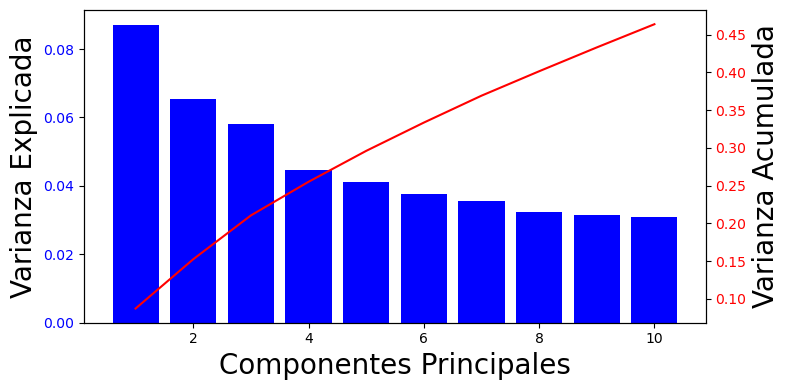

In [ ]:
# Definimos la cantidad de componentes
n_comps = 10
components = range(1,n_comps + 1)
#Creamos el objeto PCA
pca = PCA(n_components=n_comps)

# Ajustamos
pca.fit(xtrain_scal)
# Transformamos
xtrainpca = pca.transform(xtrain_scal)

# Porcentaje de la varianza explicada por cada Principal Component (PC)
eigenvalues = pca.explained_variance_ratio_

# Suma acumulada
eigenvalues_acum = pca.explained_variance_ratio_.cumsum()

# Graficamos
# Eje Izquierdo
fig, ax1 = plt.subplots(figsize=(8,4))
ax1.set_xlabel('Componentes Principales',fontsize=20)
ax1.set_ylabel('Varianza Explicada', color='k',fontsize=20)
ax1.bar(components, eigenvalues, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Eje derecho
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Varianza Acumulada', color='k',fontsize=20)
ax2.plot(components, eigenvalues_acum, color='red')
ax2.tick_params(axis='y', labelcolor='red')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

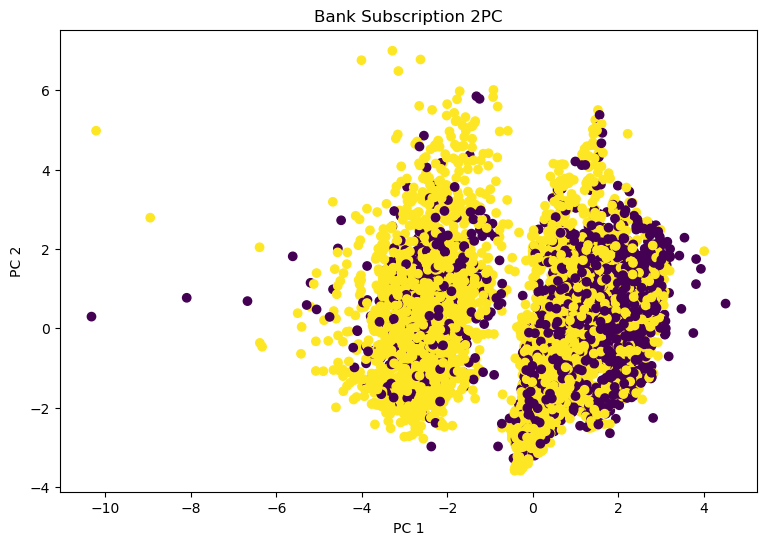

In [ ]:
# Scatter plot de muestras con 2 PC:

#Verdadero
plt.figure(figsize=(9,6))
plt.scatter(xtrainpca[:,0],xtrainpca[:,1],c=ytrain)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Bank Subscription 2PC')
plt.show()

In [ ]:
# LR con PCA
# Ajusto mi modelo a las muestras de training utilizando tanto Xtrain como Ytrain
model_lr.fit(xtrainpca, ytrain)

LogisticRegression()

In [ ]:
# Transformamos xtest
xtestpca = pca.transform(xtest_scal)

# Genero predicciones con mi modelo entrenado para las muestras de Test, utilizando solo Xtest
ypred = model_lr.predict(xtestpca)

In [ ]:
# Computo el accuracy (comparar ytest vs ypred)
test_acc = accuracy_score(ytest, ypred)
print("El accuracy es " + str(test_acc))

El accuracy es 0.6925


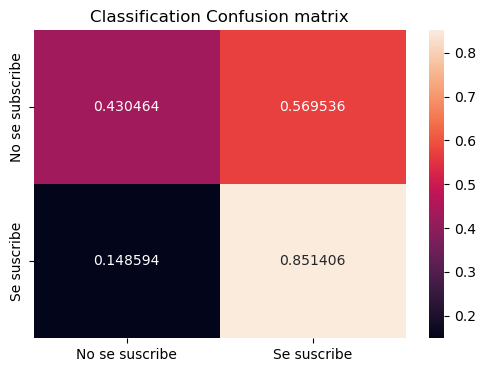

In [ ]:
# Compute confusion Matrix
cm = confusion_matrix(ytest, ypred, normalize = 'true')

df_cm = pd.DataFrame(cm, index = ['No se subscribe', 'Se suscribe'], columns = ['No se suscribe', 'Se suscribe'])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, fmt='g')
plt.title('Classification Confusion matrix')
plt.show()

In [ ]:
# Vemos que empeoraron los resultados, por lo cual parecería que LR y PCA no son el mejor camino


In [ ]:
#Probamos de nuevo SVC, usando PCA
#Creamos el modelo Support Vector Classification (SVC)

svc = svm.SVC()

#Los valores posibles de los parametros son:
#kernel: {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable, default=’rbf’
#gamma: {‘scale’, ‘auto’} or float, default=’scale’ -> 1/n_features o float no negativo
#C: float, default=1.0

param_svm = {'kernel':('poly', 'linear'), 'C':[1, 10, 50], 'gamma':[0.1,0.5,1]}

In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# cv indica la cantidad de folds
# refit nos devuelve el modelo con los mejores parametros encontrados

svc_clf = RandomizedSearchCV(svc, param_distributions = param_svm, refit = True, cv = 5,verbose = 2,n_iter=1,n_jobs=-1)

In [ ]:
svc_clf.fit(xtrainpca, ytrain.ravel())

Fitting 5 folds for each of 1 candidates, totalling 5 fits


RandomizedSearchCV(cv=5, estimator=SVC(), n_iter=1, n_jobs=-1,
                   param_distributions={'C': [1, 10, 50],
                                        'gamma': [0.1, 0.5, 1],
                                        'kernel': ('poly', 'linear')},
                   verbose=2)

In [ ]:
print("The best parameters are %s with a score of %0.2f" % (svc_clf.best_params_, svc_clf.best_score_))
# The best parameters are {'kernel': 'rbf', 'gamma': 0.01, 'C': 1} with a score of 0.90

The best parameters are {'kernel': 'linear', 'gamma': 1, 'C': 1} with a score of 0.68


In [ ]:
# Hacemos una serie de hiperparametros nuevos a partir de los resultados y volvemos a estimar:

param_svm = {'kernel':('linear', 'rbf'), 'C':[1, 100, 1000], 'gamma':[ 0.005, 0.05, 0.1 ]}
svc_clf = RandomizedSearchCV(svc, param_distributions = param_svm, refit = True, cv = 5,verbose = 2,n_iter=1,n_jobs=-1)
svc_clf.fit(xtrainpca, ytrain.ravel())
print("The best parameters are %s with a score of %0.2f" % (svc_clf.best_params_, svc_clf.best_score_))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
The best parameters are {'kernel': 'rbf', 'gamma': 0.1, 'C': 1} with a score of 0.71


In [ ]:
# Genero predicciones con mi modelo entrenado para las muestras de Test, utilizando solo Xtest
ypred = svc_clf.predict(xtestpca)

In [ ]:
# Compute confusion Matrix
cm = confusion_matrix(ytest, ypred,normalize ='true')
cm

array([[0.48013245, 0.51986755],
       [0.13855422, 0.86144578]])

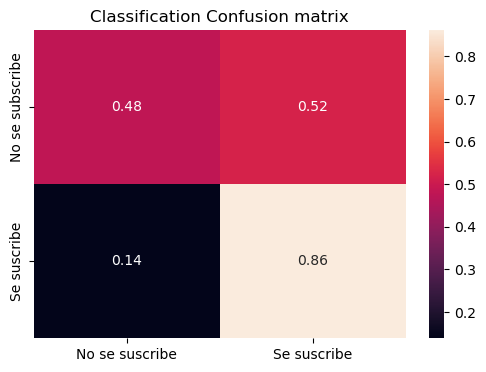

In [ ]:
df_cm = pd.DataFrame(cm, index = ['No se subscribe', 'Se suscribe'], columns = ['No se suscribe', 'Se suscribe'])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, fmt='.2f')
plt.title('Classification Confusion matrix')
plt.show()

In [ ]:
#Mejoran un poco los resultados, aun asi el resultado inicial de logistic regression sin PCA resultó mejor.